# Ovrlpy applied to vizgen receptor data map



#### Imports:

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Parameter definition:

In [3]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)


6.014108657836914e-05


In [4]:
n_slice = 2

coordinate_path = f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/detected_transcripts_S{n_slice}R1.csv'
# analysis/tiesmeys/data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/detected_transcripts_S1R1.csv'

scale=1 # scaling factor for images/coordinats. We want to end up with cell diameter ~30px (cellpose default)
# model_type='cyto2' # cellpose model name. ['dapi','cyto','cyto2']

In [5]:

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


           global_x      global_y      global_z
count  4.874067e+07  4.874067e+07  4.874067e+07
mean   4.974135e+03  3.696136e+03  2.847259e+00
std    2.237596e+03  1.731014e+03  1.945633e+00
min    5.302726e+01 -7.666222e+01  0.000000e+00
25%    3.236294e+03  2.256036e+03  1.000000e+00
50%    4.957519e+03  3.637856e+03  3.000000e+00
75%    6.799679e+03  5.120410e+03  4.000000e+00
max    9.692914e+03  7.453246e+03  6.000000e+00
n_transcripts: 48574461, panel_size: 483


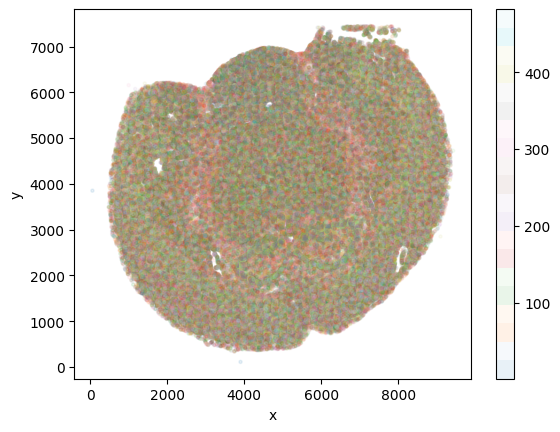

In [6]:
# Load coordinate_path data frame, read only the columns
# global_x, global_y, global_z, fov	gene:

import time

df = pd.read_csv(coordinate_path, sep=',', usecols=[2,3,4,8], header=0)[::1]

print(df.describe())


df.columns=['x','y','z','gene']
df = df[~df.gene.str.contains('Blank')]
# df.x-=df.x.min()
# df.y-=df.y.min()
# df.x/=um_per_pixel/scale
# df.y/=um_per_pixel/scale
# df.z/=um_per_pixel/scale

# df.gene.replace({'Acte1':'Gm498'})

df.gene = df.gene.astype('category')
gene_counts = df.gene.value_counts()
genes = list(gene_counts.index)

df[::200].plot.scatter(x='x',y='y',s=5,c=df[::200].gene.cat.codes,cmap='tab20',alpha=0.1)

print(f"n_transcripts: {len(df)}, panel_size: {len(genes)}")

In [7]:
signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 
signatures.columns=signatures.columns.str.replace('/','-')


/tmp/ipykernel_453326/2048503760.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


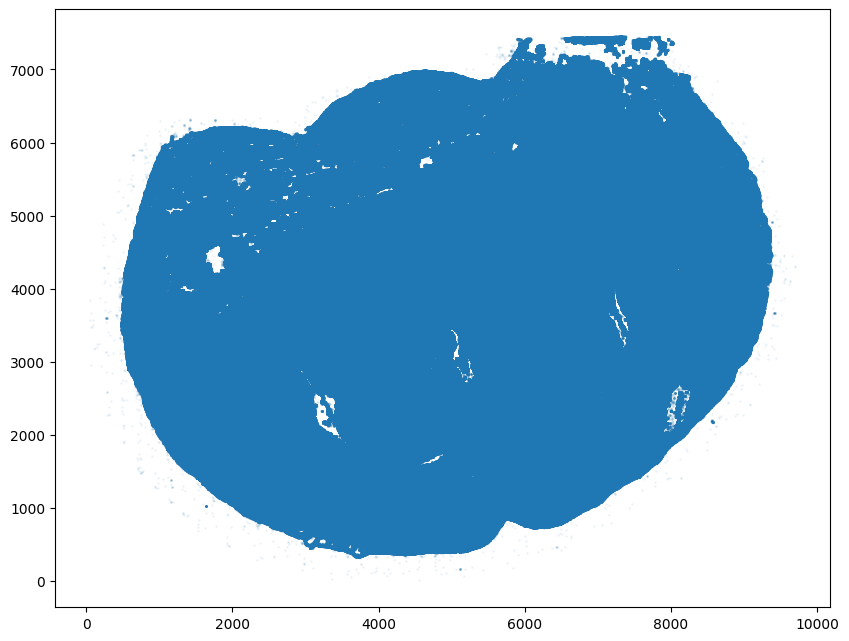

In [8]:
#
plt.figure(figsize=(10,10))


x_lims = [0,10000]
y_lims = [0,10000]

df_mask = (df.x>x_lims[0]) & (df.x<x_lims[1]) & (df.y>y_lims[0]) & (df.y<y_lims[1])

df = df[df_mask].copy()

mins = df[['x','y']].min()

# df.x-=df.x.min()
# df.y-=df.y.min()

plt.scatter(df.x,df.y,s=1,alpha=0.05)
plt.gca().set_aspect('equal') 
df.gene = df.gene.astype('str').astype('category')
gene_counts = df.gene.value_counts()
genes = gene_counts.index

# Adhere to project's global naming convention:
coordinate_df = df.copy()
del df


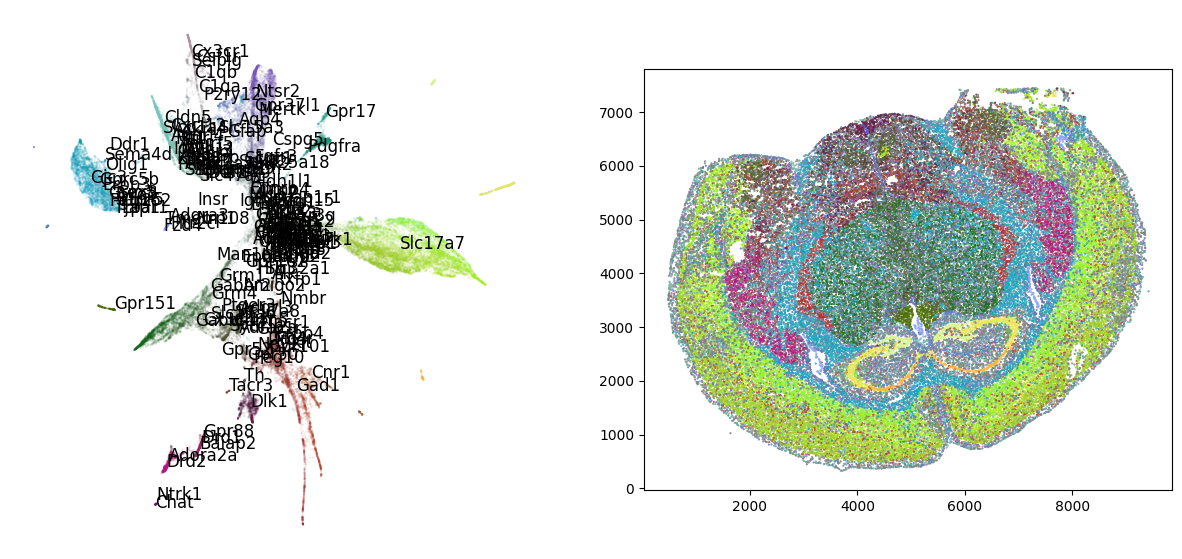

In [9]:
import ovrlpy

visualizer = ovrlpy.load_visualizer('./publication/vizgen-receptor/vizgen-receptor.vis')

signal_integrity,signal_strength = visualizer.integrity_map,visualizer.signal_map

visualizer.plot_fit()

/tmp/ipykernel_453326/1398008384.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


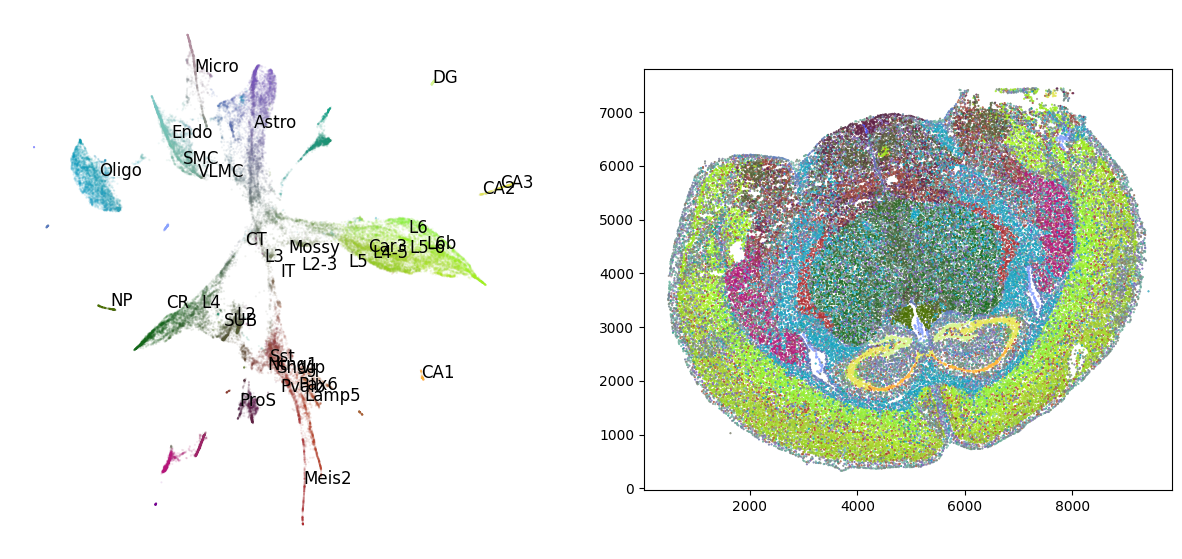

In [10]:
import numpy as np
import matplotlib.pyplot as plt

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in visualizer.genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

plt.savefig("./publication/vizgen-receptor/figures/receptor-fit",dpi=300)

In [15]:
coordinate_df

,x,y,z,gene,x_pixel,y_pixel,n_pixel,z_delim,cell_id
0,56.930107,3851.8510,5.0,Adgre1,56,3851,37323948,5.0,-1
1,183.601070,3874.0085,5.0,Adgre1,183,3874,37546991,5.0,-1
2,59.750736,3666.5576,5.0,Adgre1,59,3666,35530931,5.0,-1
3,93.463020,3573.8591,0.0,Grm4,93,3573,34629609,0.0,-1
4,83.457310,3479.3071,0.0,P2yr13,83,3479,33718551,0.0,-1
...,...,...,...,...,...,...,...,...,...
48740661,9658.556000,4446.9995,5.0,Adgre1,9658,4446,43100290,5.0,-1
48740662,9548.595000,4446.6074,3.0,Ffar4,9548,4446,43100180,3.0,-1
48740663,9692.628000,4303.6094,1.0,Nmbr,9692,4303,41714368,1.0,-1
48740664,9692.914000,4303.3433,1.0,Olig1,9692,4303,41714368,1.0,-1


In [17]:
import h5py as h5
from shapely.geometry import Polygon
import rasterio
from rasterio.features import rasterize
import tqdm

# File_features = h5. "/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy/publication/vizgen-receptor/mapmycells]$ ls /dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice1/Replicate1/cell_boundaries"

polygons = []

max_x = 0
max_y = 0

cell_id = 0

files = os.listdir(f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/cell_boundaries/')

for file in tqdm.tqdm(files,total = len(files)):
    with h5.File(f'/dh-projects/ag-ishaque/raw_data/vizgen-merfish/vz-receptor-showcase/Slice{n_slice}/Replicate1/cell_boundaries/{file}','r') as f:
        
        for i, features in enumerate (f['featuredata'].keys()):
            for j,idx_key in enumerate(f['featuredata'][features].keys()):
                
                if (isinstance(f['featuredata'][features][idx_key],h5.Dataset)):
                    # print(f['featuredata'][features][idx_key])
                    continue
                    # plt.plot(*f['featuredata'][features][idx_key]['coordinates'][0].T)

                else:
                    for m,p in enumerate(f['featuredata'][features][idx_key].keys()):                        
                        
                        polygon = Polygon(f['featuredata'][features][idx_key][p]['coordinates'][0])
                        polygons.append((polygon, cell_id))  
                        
                        max_x = max(max_x,f['featuredata'][features][idx_key][p]['coordinates'][0][:,0].max())
                        max_y = max(max_y,f['featuredata'][features][idx_key][p]['coordinates'][0][:,1].max())
                        
                        # plt.plot(*f['featuredata'][features][idx_key][p]['coordinates'][0].T)
                        
            cell_id+=1
            

segmentation_map = rasterize(polygons, out_shape=signal_strength.shape[::-1], fill=np.nan, all_touched=True, dtype=float)


segmentation_map_df = pd.DataFrame(np.where(~np.isnan(segmentation_map.T)),index=['y','x']).T
segmentation_map_df['cell_id'] = segmentation_map[segmentation_map_df.x,segmentation_map_df.y].astype(int)

ovrlpy.pre_process_coordinates(coordinate_df)

coordinate_px_df = coordinate_df[['x_pixel','y_pixel','gene']].copy().rename(columns={'x_pixel':'y','y_pixel':'x'})
merged_df = pd.merge(coordinate_px_df,segmentation_map_df,how='left',on=['x','y'])
coordinate_df['cell_id'] = merged_df.cell_id.fillna(-1).astype(int).values


cell_annotation_df = merged_df[['x','y','cell_id']].groupby('cell_id').mean()
cell_annotation_df.index = cell_annotation_df.index.astype(int)
cell_annotation_df['counts'] = merged_df.groupby('cell_id').size()


del coordinate_px_df, segmentation_map_df

/tmp/ipykernel_453326/3582038561.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cell_annotation_df["above_threshold"] = signal_integrity_integration_groups.apply(lambda x: np.mean(x.signal_integrity_>0.3))


<Axes: title={'center': 'mean purity distribution, MERFISH receptor'}, ylabel='Frequency'>

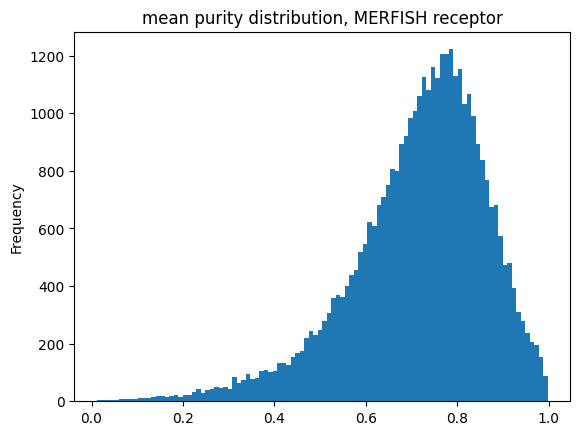

In [19]:
segmentation_map_ = segmentation_map.copy()
segmentation_map_[np.isnan(segmentation_map)]=-1
segmentation_map_ = segmentation_map_.astype(int)

signal_integrity_ = signal_integrity.copy()
signal_integrity_[signal_strength<1]=np.nan

signal_integrity_integration_mask = (signal_strength>1.5) & (segmentation_map_.T>=0)

signal_integrity_integration_df = pd.DataFrame(signal_integrity_[signal_integrity_integration_mask].flatten(),columns=['signal_integrity_'])
signal_integrity_integration_df['segmentation_map'] = segmentation_map_.T[signal_integrity_integration_mask].flatten().astype(int)

signal_integrity_integration_groups = signal_integrity_integration_df.groupby('segmentation_map')

cell_annotation_df["mean_purity"] = signal_integrity_integration_groups.mean().signal_integrity_
cell_annotation_df["min_purity"] = signal_integrity_integration_groups.min().signal_integrity_
cell_annotation_df["median_purity"] = signal_integrity_integration_groups.median().signal_integrity_
cell_annotation_df["quartile_purity"] = signal_integrity_integration_groups.quantile(0.75).signal_integrity_
cell_annotation_df["above_threshold"] = signal_integrity_integration_groups.apply(lambda x: np.mean(x.signal_integrity_>0.3))
cell_annotation_df["area"] = signal_integrity_integration_groups.size()


cell_annotation_df.mean_purity.plot.hist(bins=100,title='mean purity distribution, MERFISH receptor')

# plt.scatter(cell_annotation_df.x,cell_annotation_df.y,s=1,c=cell_annotation_df.min_purity,cmap='viridis')

/tmp/ipykernel_453326/2914987234.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bottom_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=cell_ids).fillna(0)
/tmp/ipykernel_453326/2914987234.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  top_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=cell_ids).fillna(0)
/tmp/ipykernel_453326/2914987234.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curren

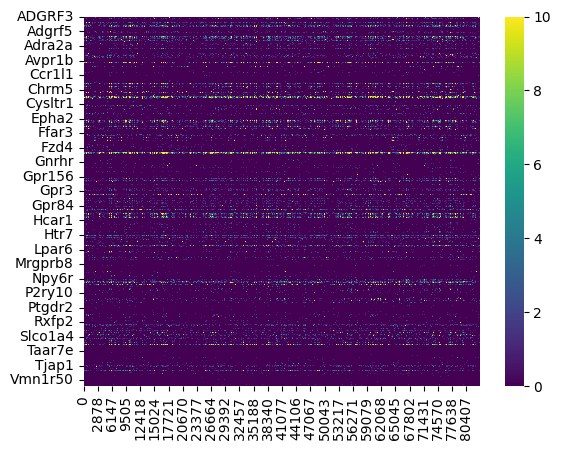

In [21]:
import seaborn as sns 

cell_ids = sorted(coordinate_df[(coordinate_df.cell_id>-1).values].cell_id.unique().astype(int))

bottom_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=cell_ids).fillna(0)
top_count_mtx = pd.DataFrame(index=coordinate_df.gene.cat.categories,columns=cell_ids).fillna(0)


bottom_counts = coordinate_df[(coordinate_df.z<coordinate_df.z_delim)&(coordinate_df.cell_id>-1).values].groupby("gene").apply(lambda x:x.cell_id.value_counts())
top_counts = coordinate_df[(coordinate_df.z>coordinate_df.z_delim)&(coordinate_df.cell_id>-1).values].groupby("gene").apply(lambda x:x.cell_id.value_counts())

bottom_counts_dict = bottom_counts.to_dict()
top_counts_dict = top_counts.to_dict()

for (gene, cell_id), count in tqdm.tqdm(bottom_counts_dict.items(), total=len(bottom_counts_dict)):
    bottom_count_mtx.at[gene, cell_id] = count
for (gene, cell_id), count in tqdm.tqdm(top_counts_dict.items(), total=len(top_counts_dict)):
    top_count_mtx.at[gene, cell_id] = count

# # Fill matrices using the dictionaries
# for g in tqdm.tqdm(coordinate_df.gene.cat.categories, total=len(coordinate_df.gene.cat.categories)):
#     if g in bottom_counts_dict:
#         for cell_id, count in bottom_counts_dict[g].items():
#             bottom_count_mtx.at[g, cell_id] = count
#     if g in top_counts_dict:
#         for cell_id, count in top_counts_dict[g].items():
#             top_count_mtx.at[g, cell_id] = count

# for i,g in tqdm.tqdm(enumerate(coordinate_df.gene.cat.categories),total=len(coordinate_df.gene.cat.categories)):
#     # print(bottom_counts.loc[c])
#     bottom_count_mtx.at[g] = bottom_counts[g]
#     top_count_mtx.at[g] = top_counts[g]
    
bottom_count_mtx.fillna(0,inplace=True)
top_count_mtx.fillna(0,inplace=True)
    
sns.heatmap(top_count_mtx,cmap='viridis',vmax=10)

import anndata
adata_bottom_count_mtx = anndata.AnnData(bottom_count_mtx.T)
adata_top_count_mtx = anndata.AnnData(top_count_mtx.T)

adata_bottom_count_mtx.write_h5ad("./publication/vizgen-receptor/top-bottom-qc/mapmycells/bottom_count_mtx_receptor.h5ad")
adata_top_count_mtx.write_h5ad("./publication/vizgen-receptor/top-bottom-qc/mapmycells/top_count_mtx_receptor.h5ad")

In [29]:
import os


def load_mapmycells_csv(region='whole'):
    files = os.listdir(f"publication/vizgen-receptor/top-bottom-qc/mapmycells/{region}/")
    csv = sorted([f for f in files if f.endswith(".csv")])[-1]
    
    mapmycells_df = pd.read_csv(f"publication/vizgen-receptor/top-bottom-qc/mapmycells/{region}/{csv}",index_col=0,skiprows=4)
    
    return mapmycells_df

(6.0, 0.0)

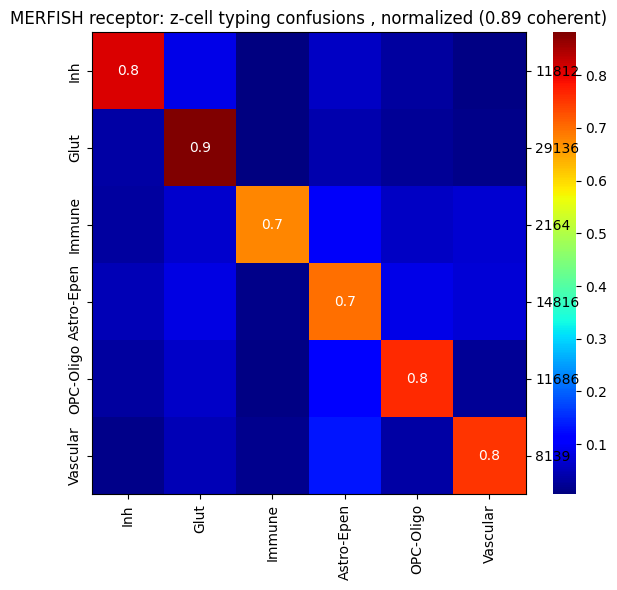

In [30]:
import seaborn as sns

# Correlation:
mapmycells_df_bottom = load_mapmycells_csv('bottom')
mapmycells_df_top = load_mapmycells_csv('top')


mapmycells_df_top['family_name'] = mapmycells_df_top.class_name.str.split(' ').str[-1]#.astype('category')
mapmycells_df_bottom['family_name'] = mapmycells_df_bottom.class_name.str.split(' ').str[-1]#.astype('category')
# all_classes = sorted(list(set(mapmycells_df_top['family_name'].unique()).union(set(mapmycells_df_bottom['family_name'].unique()))))
all_classes = 'Inh','Glut','Immune','Astro-Epen','OPC-Oligo','Vascular'
inh_classes = 'GABA','Sero'#,'Dopa'
mapmycells_df_bottom.loc[mapmycells_df_bottom['family_name'].isin(inh_classes),'family_name'] = 'Inh'
mapmycells_df_top.loc[mapmycells_df_top['family_name'].isin(inh_classes),'family_name'] = 'Inh'

global_prediction_coherence =(mapmycells_df_top.family_name.astype(str)==mapmycells_df_bottom.family_name.astype(str)).mean()

(mapmycells_df_top == mapmycells_df_bottom).mean()

celltype_confusions = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crossconfusions = celltype_confusions.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_confusions.index:
    for j in celltype_confusions.columns:
        celltype_confusions.loc[i,j] = (((mapmycells_df_top['family_name']==i)&(mapmycells_df_bottom['family_name']==j))).sum()
        if i==j:
            celltype_crossconfusions.loc[i,j]=np.nan
            continue
        celltype_crossconfusions.loc[i,j] = celltype_confusions.loc[i,j]
        
    counts[i] = ((mapmycells_df_top['family_name']==i)|(mapmycells_df_bottom['family_name']==i)).sum()

celltype_confusions = celltype_confusions+celltype_confusions.T
celltype_confusions /= np.eye(len(celltype_confusions))+1
# celltype_confusions.index = celltype_confusions.index.str.split(' ').str[1:].str.join(' ')
# celltype_confusions.columns = celltype_confusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_confusions/=celltype_confusions.sum(1)
celltype_confusions = celltype_confusions.T

celltype_crossconfusions = celltype_crossconfusions+celltype_crossconfusions.T
celltype_crossconfusions.index = celltype_crossconfusions.index.str.split(' ').str[1:].str.join(' ')
celltype_crossconfusions.columns = celltype_crossconfusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_crossconfusions/=celltype_crossconfusions.sum(1)
celltype_crossconfusions = celltype_crossconfusions.T

for i in range(len(celltype_confusions.index)):
    annotations.iloc[i,i] = f"{celltype_confusions.iloc[i,i]:.1f}"        
    
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
sns.heatmap(celltype_confusions,annot=annotations,ax=ax,cmap='jet',fmt='')
plt.title(f"MERFISH receptor: z-cell typing confusions , normalized ({global_prediction_coherence:.2f} coherent)")

# Set the secondary y-axis ticks and labels
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(counts.astype(int).astype(str))
ax2.set_ylim(ax.get_ylim())

# ax = plt.subplot(122)
# sns.heatmap(celltype_crossconfusions,ax=ax,cmap='jet')
# plt.title('vertical cell typing cross-confusion matrix, normalized')


# # Set the secondary y-axis ticks and labels
# ax2 = ax.twinx()
# ax2.set_yticks(ax.get_yticks())
# ax2.set_yticklabels(counts.astype(int).astype(str))
# ax2.set_ylim(ax.get_ylim())



(34.0, 0.0)

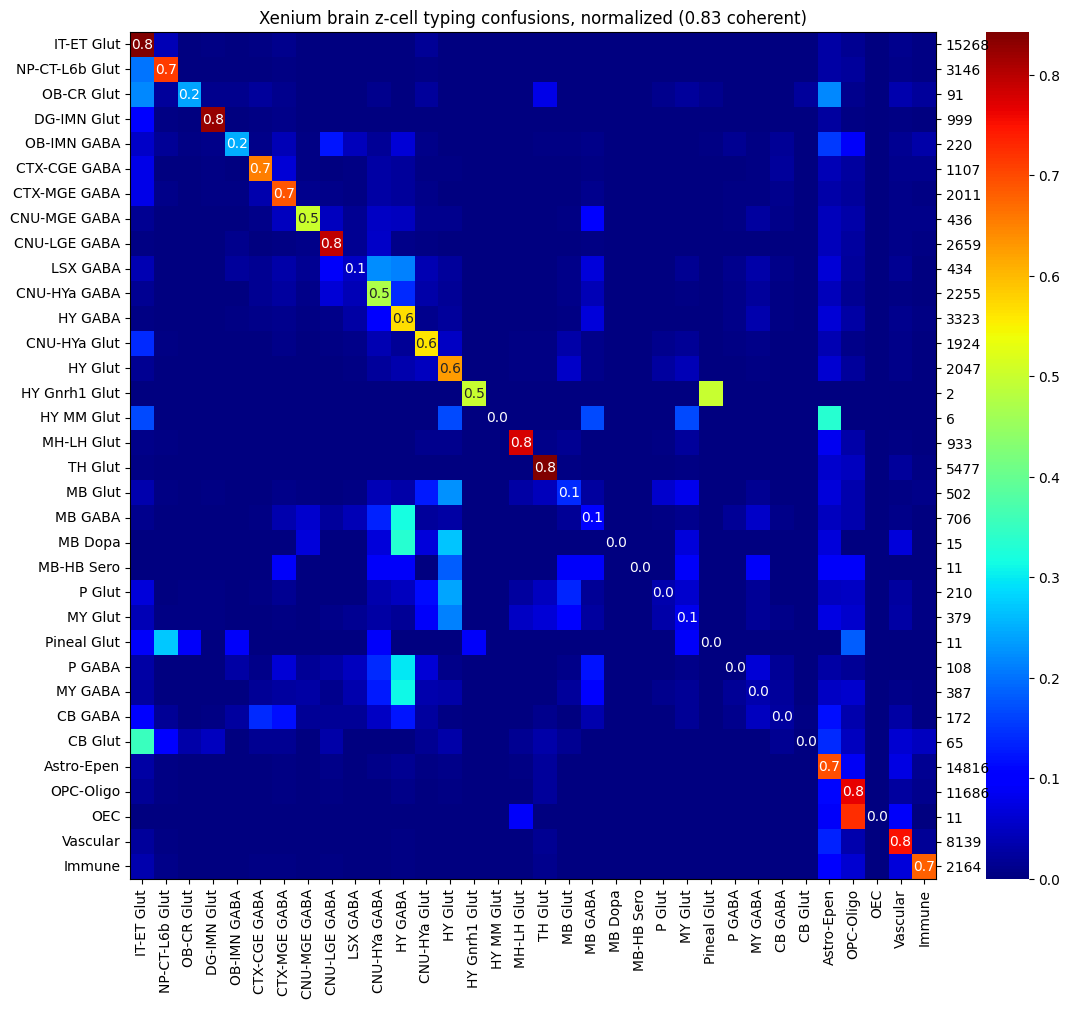

In [32]:
import seaborn as sns

# Correlation:
mapmycells_df_bottom = load_mapmycells_csv('bottom')
mapmycells_df_top = load_mapmycells_csv('top')

# ratio of coherently predicted cell types across the vertical demarcation:
global_prediction_coherence =(mapmycells_df_top.class_name.astype(str)==mapmycells_df_bottom.class_name.astype(str)).mean()

mapmycells_df_top['family_name'] = mapmycells_df_top.class_name.str.split(' ').str[-1].astype('category')
mapmycells_df_bottom['family_name'] = mapmycells_df_bottom.class_name.str.split(' ').str[-1].astype('category')
all_classes = sorted(list(set(mapmycells_df_top['class_name'].unique()).union(set(mapmycells_df_bottom['class_name'].unique()))))

(mapmycells_df_top == mapmycells_df_bottom).mean()

celltype_confusions = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crossconfusions = celltype_confusions.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_confusions.index:
    for j in celltype_confusions.columns:
        celltype_confusions.loc[i,j] = ((mapmycells_df_top['class_name']==i)&(mapmycells_df_bottom['class_name']==j)).sum()
        if i==j:
            celltype_crossconfusions.loc[i,j]=np.nan
            continue
        celltype_crossconfusions.loc[i,j] = celltype_confusions.loc[i,j]
        
    counts[i] = ((mapmycells_df_top['class_name']==i)|(mapmycells_df_bottom['class_name']==i)).sum()


celltype_confusions = celltype_confusions+celltype_confusions.T
celltype_confusions /= np.eye(len(celltype_confusions))+1
celltype_confusions.index = celltype_confusions.index.str.split(' ').str[1:].str.join(' ')
celltype_confusions.columns = celltype_confusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_confusions/=celltype_confusions.sum(1)
celltype_confusions = celltype_confusions.T


celltype_crossconfusions = celltype_crossconfusions+celltype_crossconfusions.T
celltype_crossconfusions.index = celltype_crossconfusions.index.str.split(' ').str[1:].str.join(' ')
celltype_crossconfusions.columns = celltype_crossconfusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_crossconfusions/=celltype_crossconfusions.sum(1)
celltype_crossconfusions = celltype_crossconfusions.T

for i in range(len(celltype_confusions.index)):
    annotations.iloc[i,i] = f"{celltype_confusions.iloc[i,i]:.1f}"        
    
fig = plt.figure(figsize=(13,11))
ax = plt.subplot(111)
sns.heatmap(celltype_confusions,annot=annotations,ax=ax,cmap='jet',fmt='')
plt.title(f"Xenium brain z-cell typing confusions, normalized ({global_prediction_coherence:.2f} coherent)")

# Set the secondary y-axis ticks and labels
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(counts.astype(int).astype(str))
ax2.set_ylim(ax.get_ylim())

# ax = plt.subplot(122)
# sns.heatmap(celltype_crossconfusions,ax=ax,cmap='jet')
# plt.title('vertical cell typing cross-confusion matrix, normalized')


# # Set the secondary y-axis ticks and labels
# ax2 = ax.twinx()
# ax2.set_yticks(ax.get_yticks())
# ax2.set_yticklabels(counts.astype(int).astype(str))
# ax2.set_ylim(ax.get_ylim())


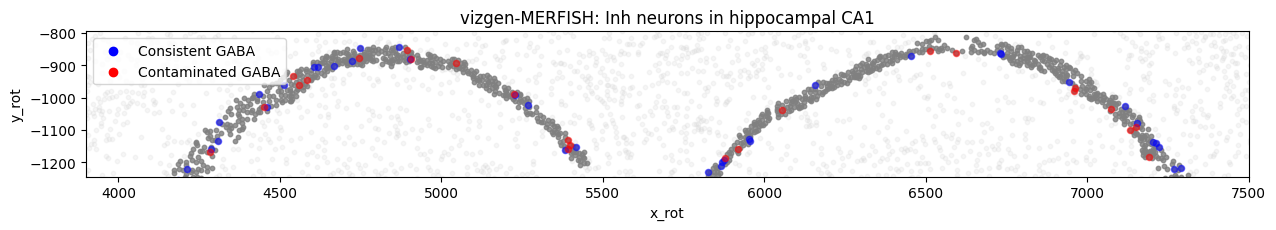

In [63]:
# plt.figure(figsize=(20,5))

from scipy.ndimage import gaussian_filter

is_dense = (gaussian_filter((gaussian_filter(signal_strength,15)>3).astype(float),13)>0.4)[cell_annotation_df.x.astype(int),cell_annotation_df.y.astype(int)]
is_ca1 = is_dense&((cell_annotation_df.x*3-cell_annotation_df.y/1.5)<4000)

phi = 0.21-np.pi/2
rotation_matrix = np.array([[np.cos(phi),-np.sin(phi)],[np.sin(phi),np.cos(phi)]])
rotated_coords = np.dot(rotation_matrix,np.array([cell_annotation_df.x,cell_annotation_df.y])).T

cell_annotation_df['x_rot'] = rotated_coords[:,0]   
cell_annotation_df['y_rot'] = rotated_coords[:,1]


plt.figure(figsize=(15,5))
ax = plt.subplot(111)
# # plt.scatter(cell_annotation_df.x,cell_annotation_df.y, c=mapmycells_df_top.class_name==mapmycells_df_bottom.class_name,s=1,alpha=0.5,cmap="viridis")
# plt.scatter(cell_annotation_df.x,cell_annotation_df.y, c=(mapmycells_df_top.class_name.str.contains('GABA'))|(mapmycells_df_bottom.class_name.str.contains('GABA')),s=10,alpha=0.9,cmap="Blues")
# plt.scatter(cell_annotation_df.x,cell_annotation_df.y, c=(mapmycells_df_top.class_name.str.contains('GABA'))^(mapmycells_df_bottom.class_name.str.contains('GABA')),s=10,alpha=0.4,cmap="Reds",)

cell_annotation_df.plot.scatter(x='x_rot',y='y_rot',c='lightgrey',s=10,alpha=0.2,ax=ax)
cell_annotation_df[is_ca1].plot.scatter(x='x_rot',y='y_rot',c='Grey',s=10,alpha=0.8,ax=ax)
cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))&(mapmycells_df_bottom.class_name.str.contains('GABA')))].plot.scatter(x='x_rot',y='y_rot',c='blue',s=20,alpha=0.5,ax=ax)
cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))^(mapmycells_df_bottom.class_name.str.contains('GABA')))].plot.scatter(x='x_rot',y='y_rot',c='red',s=20,alpha=0.5,ax=ax)

ca1_inh = cell_annotation_df[is_ca1&((mapmycells_df_top.class_name.str.contains('GABA'))|(mapmycells_df_bottom.class_name.str.contains('GABA')))]
 
plt.xlim(2600*1.5,5000*1.5)
plt.ylim(-830*1.5,-530*1.5)

plt.gca().set_aspect('equal', )
plt.title('vizgen-MERFISH: Inh neurons in hippocampal CA1')

plt.legend([plt.scatter([],[],c='b'),plt.scatter([],[],c='r') ],['Consistent GABA','Contaminated GABA',],)

(6.0, 0.0)

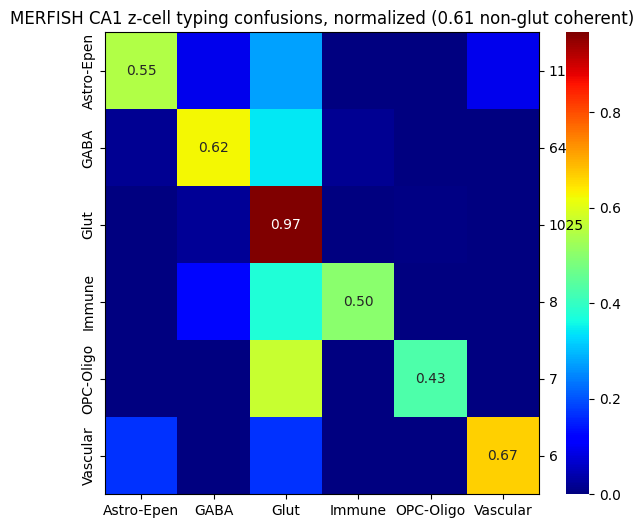

In [64]:

ca1_df_top = mapmycells_df_top[is_ca1].copy()
ca1_df_bottom = mapmycells_df_bottom[is_ca1].copy()


ca1_df_top['family_name'] = ca1_df_top.class_name.str.split(' ').str[-1].astype('str')
# ca1_df_top.loc[ca1_df_top.family_name.str.contains('GABA'),'family_name']='GABA'
ca1_df_bottom['family_name'] = ca1_df_bottom.class_name.str.split(' ').str[-1].astype('str')
# ca1_df_bottom.loc[ca1_df_bottom.family_name.str.contains('GABA'),'family_name']='GABA'

all_classes = sorted(list(set(ca1_df_top['family_name'].unique()).union(set(ca1_df_bottom['family_name'].unique()))))


global_prediction_coherence =(ca1_df_top.family_name.astype(str)==ca1_df_bottom.family_name.astype(str))[~((ca1_df_top.family_name=='Glut')&(ca1_df_bottom.family_name=='Glut'))].mean()

celltype_confusions = pd.DataFrame(index=all_classes,columns=all_classes).astype(float)
celltype_crossconfusions = celltype_confusions.copy()

counts = pd.Series(index=all_classes,dtype=int)
annotations = pd.DataFrame(index=all_classes,columns=all_classes).astype(str)
annotations[:] = ''

for i in celltype_confusions.index:
    for j in celltype_confusions.columns:
        celltype_confusions.loc[i,j] = ((ca1_df_top['family_name']==i)&(ca1_df_bottom['family_name']==j)).sum()
        if i==j:
            celltype_crossconfusions.loc[i,j]=np.nan
            continue
        celltype_crossconfusions.loc[i,j] = celltype_confusions.loc[i,j]
        
    counts[i] = ((ca1_df_top['family_name']==i)|(ca1_df_bottom['family_name']==i)).sum()


celltype_confusions = celltype_confusions+celltype_confusions.T
celltype_confusions /= np.eye(len(celltype_confusions))+1
# celltype_confusions.index = celltype_confusions.index.str.split(' ').str[1:].str.join(' ')
# celltype_confusions.columns = celltype_confusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_confusions[:] = celltype_confusions/celltype_confusions.sum(1)
celltype_confusions = celltype_confusions.T


celltype_crossconfusions = celltype_crossconfusions+celltype_crossconfusions.T
celltype_crossconfusions.index = celltype_crossconfusions.index.str.split(' ').str[1:].str.join(' ')
celltype_crossconfusions.columns = celltype_crossconfusions.columns.str.split(' ').str[1:].str.join(' ')

celltype_crossconfusions/=celltype_crossconfusions.sum(1)
celltype_crossconfusions = celltype_crossconfusions.T

for i in range(len(celltype_confusions.index)):
    annotations.iloc[i,i] = f"{celltype_confusions.iloc[i,i]:.2f}"        
    
fig = plt.figure(figsize=(7,6))
ax = plt.subplot(111)
sns.heatmap(celltype_confusions,annot=annotations,ax=ax,cmap='jet',fmt='')
plt.title(f"MERFISH CA1 z-cell typing confusions, normalized ({global_prediction_coherence:.2f} non-glut coherent)")

# Set the secondary y-axis ticks and labels
ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_yticklabels(counts.astype(int).astype(str))
ax2.set_ylim(ax.get_ylim())